# This is your playground! Leaderboard를 정복해 주세요!

### 학습 목표

데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.

캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.

앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.

하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.

Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.


In [42]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# 데이터 경로 지정 baseline커널의 기존코드를 자신의 경로에 맞게 변경
# train_data_path = join('../input', 'train.csv') 기존 baseline 커널의 코드
# sub_data_path = join('../input', 'test.csv')
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [44]:
# 데이터 불러오기
data = pd.read_csv(train_data_path) # training 데이터
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [45]:
# 학습 데이터에서 라벨 제거하기
y = data['price'] # price 컬럼은 따로 y라는 변수에 저장한 후 y데이터니까 sub 데이터컬럼
del data['price'] # 해당 컬럼 지우기

print(data.columns) # price 칼럼 지워진거 확인할수 있음

# 학습 데이터와 테스트 데이터 합치기
train_len = len(data) # 나중에 사용할거 대비해 train_len에 training data(data) 개수를 저장
data = pd.concat((data, sub), axis=0) # data, sub를 concat으로 합쳐 data가 전체데이터가됨
print(len(data))
data.head() # 합친거 확인해보기

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


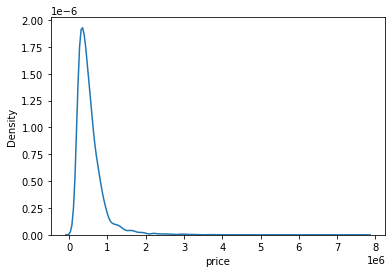

In [46]:
# seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인
sns.kdeplot(y)
plt.show() # price는 왼쪽으로 크게 치우쳐 있는 형태를 보입니다.

변수설명

ID : 집을 구분하는 번호

date : 집을 구매한 날짜

price : 집의 가격(Target)

bedrooms : 침실 개수

bathrooms : 화장실 개수

sqft_living : 거주하는 건물 면적

sqft_lot : 대지 면적

floors : 층 수

waterfront : 물가인지

view : 뷰

condition : 집 상태

grade : King County grading 시스템 기준으로 매긴 집의 

sqft_above : 지하실을 제외한 평방 피트(면적)

sqft_basement : 지하실의 평방 피트(면적)

yr_built : 지어진 년도

yr_renovated : 집을 재건축한 년도

zipcode : 우편번호

lat : 위도

long : 경도

sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있

<AxesSubplot:>

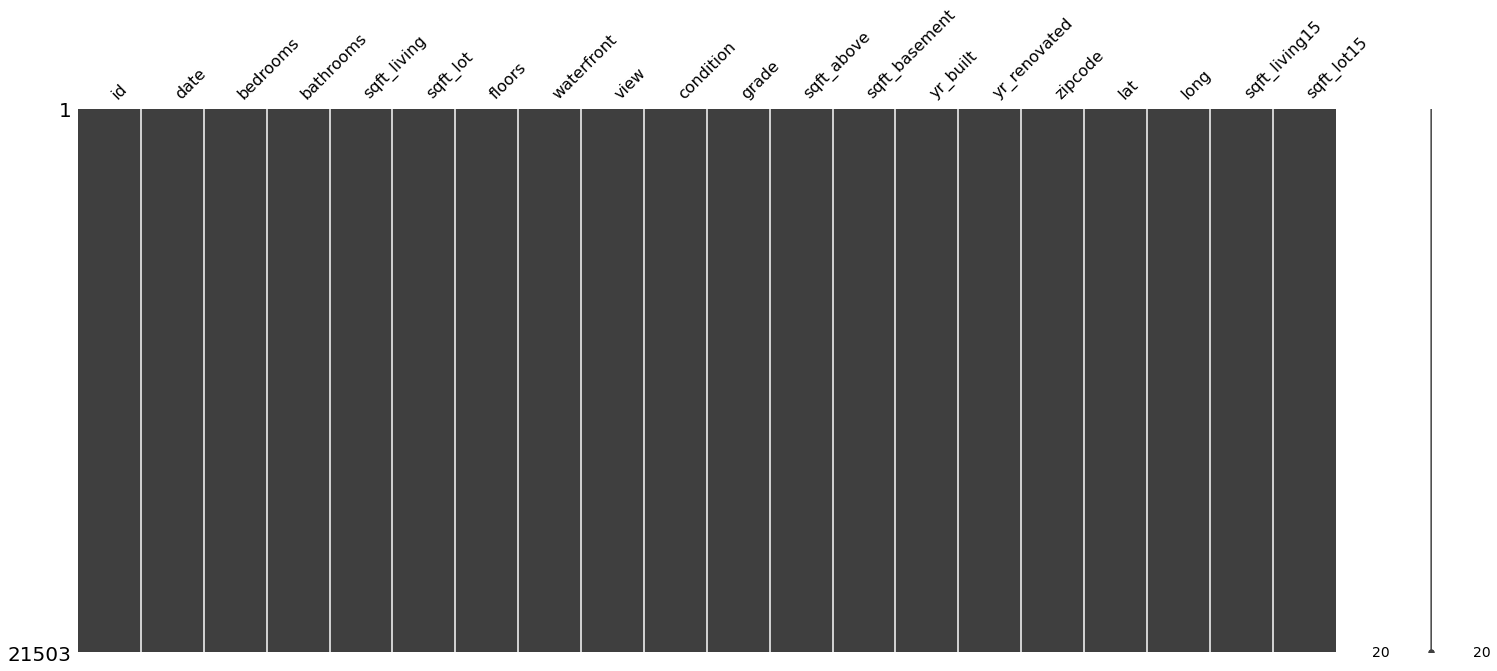

In [47]:
# 간단한 전처리

# 데이터의 결측 상태를 시각화해서 살펴보기
msno.matrix(data) # missingno 라이브러리의 matrix 함수를 사용

# data라는 DataFrame을 매트릭스 모양 그대로 시각화
# 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옵니다
# 결측치가 없어서 모두 검정색으로 나옴

In [48]:
# 모든 컬럼 결측치 확인하고 결측치 데이터 뽑아서 개수 새기
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [49]:
# id, date 변수 정리
sub_id = data['id'][train_len:] # 나중에 필요할지 모르니 id컬럼을 sub_id로 저장해둠
del data['id'] # 필요없는 id 컬럼 제거
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [50]:
# date 컬럼은 apply 함수로 필요한 부분만 잘라줍니다.
data['date'] = data['date'].apply(lambda x : str(x[:6])) 
# str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 
# 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


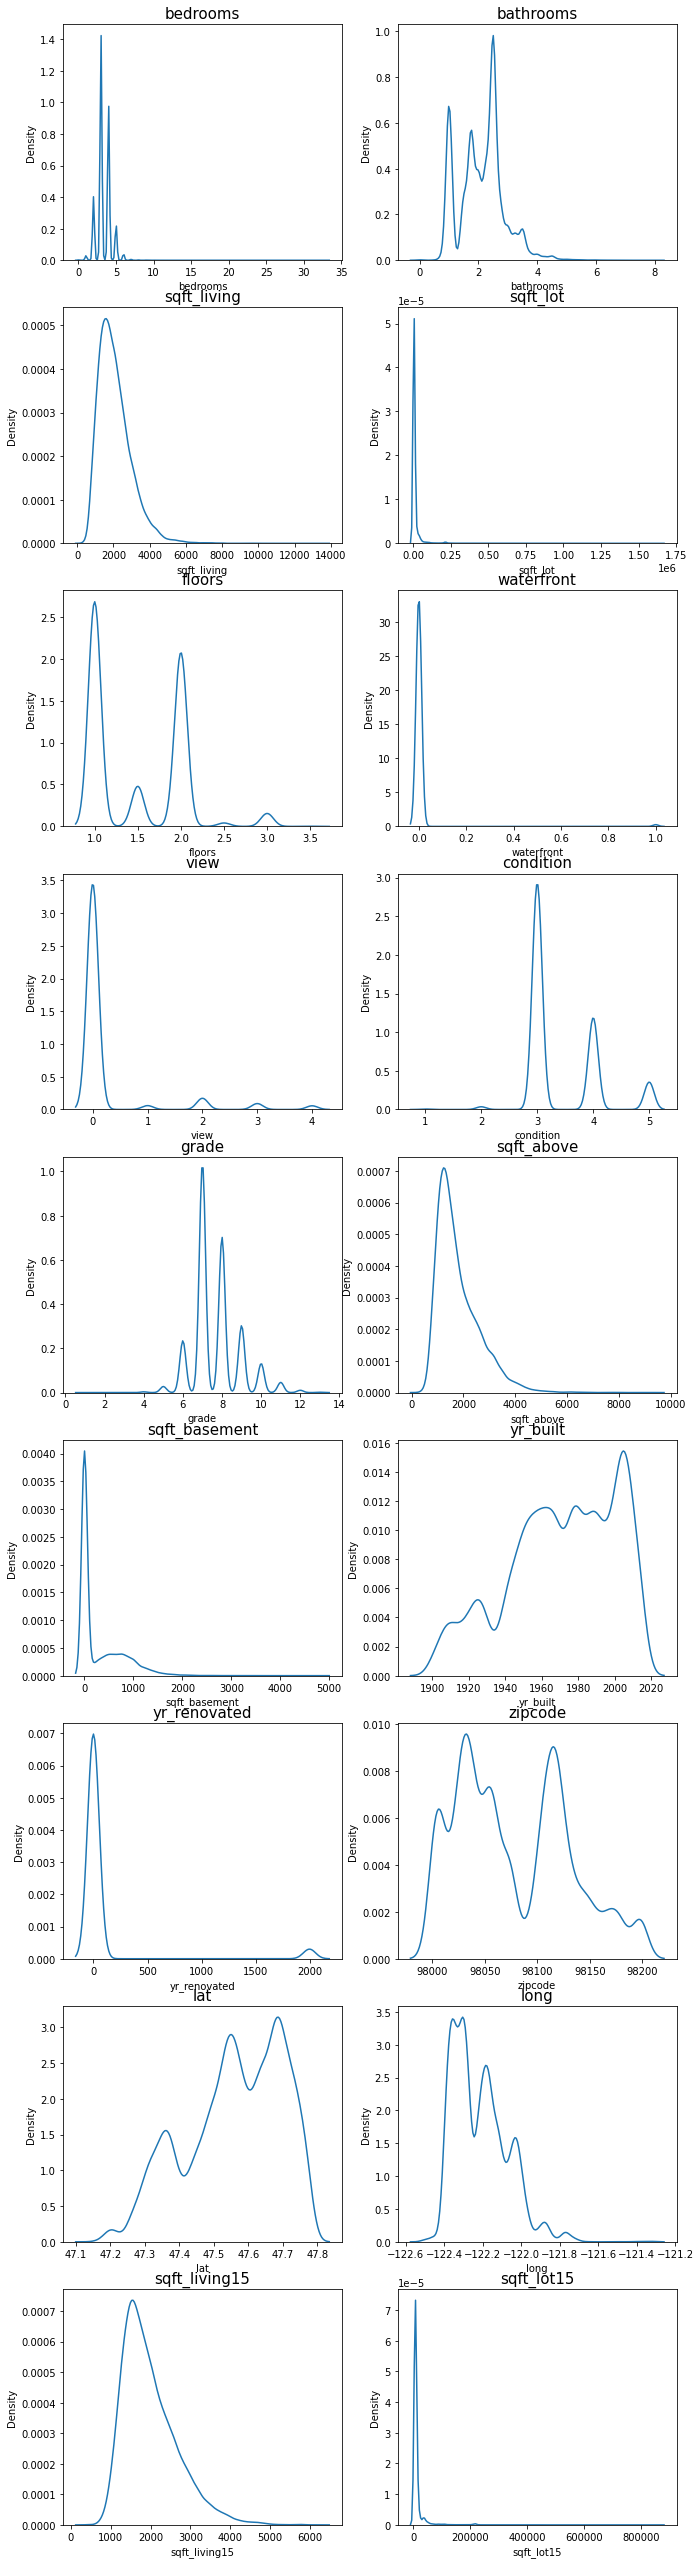

In [51]:
# 각 변수들의 분포 확인 / 코드로 전체 그래프를 그려보자 = 위그래프
fig, ax = plt.subplots(9, 2, figsize=(11, 46)) # figsize 그래프 크기 조절

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9): # 10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
# kdeplot() : 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 시각화 한다
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [52]:
# 아래의 치우친 컬럼들을 skew_columns 리스트 안에 담고 로그 변환 하기
# 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) # np.log1p()를 활용해서 로그 변환
# numpy.log1p() : 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수
print(data[c])

0       7.201171
1       7.908755
2       7.496097
3       7.713785
4       7.409136
          ...   
6463    7.186144
6464    7.244942
6465    7.193686
6466    6.928538
6467    7.252054
Name: sqft_living15, Length: 21503, dtype: float64


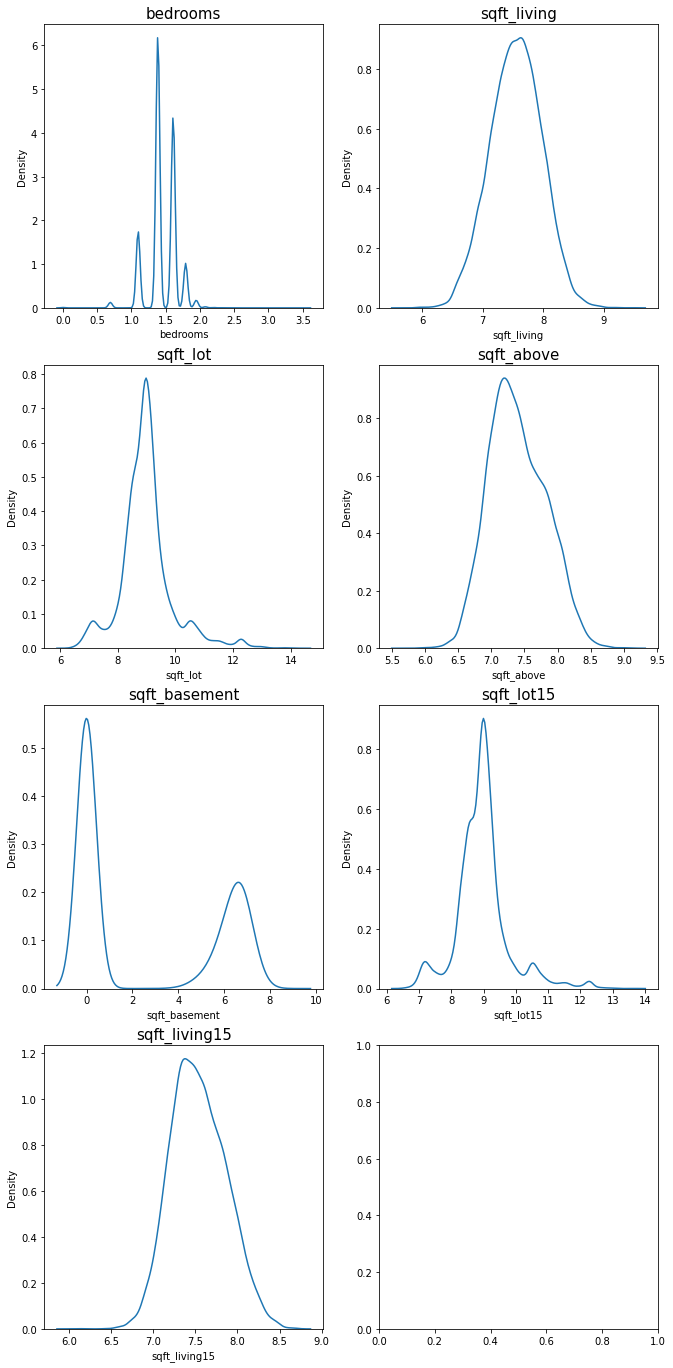

In [53]:
# 변환 하고 분포 다시 확인하기 = 아래 그래프
fig, ax = plt.subplots(4, 2, figsize=(11, 24))

count = 0
for row in range(4): 
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
# 이전보다 훨씬 치우침이 줄어든 분포를 확인할 수 있다

In [54]:
# 전체 데이터 나누기
# train_len을 인덱스로 활용
x = data.iloc[:train_len, :] # 학습데이터는 :train_len까지 x로 저장
sub = data.iloc[train_len:, :] # 추론을 하는 테스트 데이터는 train_len:부터 sub 로저장
print(x.shape) # (15035, 19)
print(sub.shape) # (6468, 19)

(15035, 19)
(6468, 19)


In [55]:
# Average Blending
# 여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들어보자
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]
print(models)

[{'model': GradientBoostingRegressor(random_state=2019), 'name': 'GradientBoosting'}, {'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=2019, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None), 'name': 'XGBoost'}, {'model': LGBMRegressor(random_state=2019), 'name': 'LightGBM'}]


In [56]:
# Cross Validation # 교차 검증을 통해 모델의 성능을 간단히 평가
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


In [57]:
# Make Submission File
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

# 함수를 활용해서 예측값을 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred)) 
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [58]:
# sample_submission.csv 파일을 확인
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head() # id와 price의 두 가지 열로 구성

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [59]:
# id와 price로 구성된 데이터 프레임을 만들어주도록 하겠습니다.
result = pd.DataFrame({
    'id' : sub_id, 'price' : y_pred})

result.head()


,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [60]:
# 다음 코드로 submission.csv 파일을 저장
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [61]:
# 다시 한번, 내 입맛대로 데이터 준비하기
# 다시 데이터를 가져오는 것부터 시작
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head() # 최초 데이터라 전처리 안되어 있음

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [62]:
# Baseline 커널과 달리, int(정수형) 데이터로 처리, 모델이 date도 예측을 위한 특성으로 활용
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [63]:
# 두 번째로 처리해야 할 것은 바로 타겟 데이터에 해당하는 price 컬럼
y = train['price'] # y 변수에 price를 넣어두고 
del train['price'] # train에서는 삭제

print(train.columns) # price 삭제되서 컬럼을 확인할수 없음

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [64]:
# 마지막으로 id 컬럼을 삭제하는 것까지 하면 기본적인 전처리는 모두 마무리
del train['id']

print(train.columns) # id 칼럼 확인할수 없음

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [65]:
# test 데이터에 대해서도 같은 작업을 진행
# test에는 훈련 데이터셋과는 다르게 price에 대한 처리는 해주지 않아도 된다
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [66]:
y # 타겟 데이터 y값 확인

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

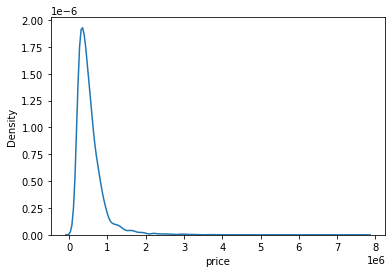

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [67]:
# seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인
sns.kdeplot(y)
plt.show() # price는 왼쪽으로 크게 치우쳐 있는 형태를 보입니다.

# y는 np.log1p() 함수를 통해 로그 변환
y = np.log1p(y)
y

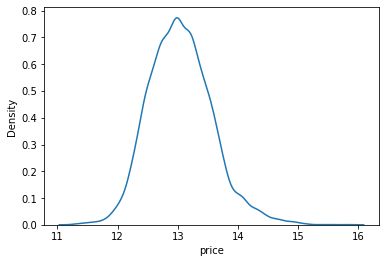

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [68]:
# 정규분포 잘 되었나 다시 확인
sns.kdeplot(y)
plt.show() # 비교적 완만한 정규분포의 형태로 잘 변환

train.info() # info() 함수로 전체 데이터의 자료형을 한눈에 확인 
# 모두 실수 또는 정수 자료형으로 변환해서 문제 없이 모델 학습에 활용할 수 있음

In [69]:
# RMSE 계산
from sklearn.model_selection import train_test_split # 훈련데이터와 검증데이터로 나눌때씀
from sklearn.metrics import mean_squared_error # RMSE 점수를 계산할때 필요함

# 대회에서 점수를 매기는 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓자
def rmse(y_test, y_pred): # y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
# 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점
# exp로 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을수있음

# 네 가지 모델 가져오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None # 이게 초기값입니다. None을 넘겨주면 모델 내부에서 임의로 선택  
random_state=2020  # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest] # 모델을 models라는 리스트에 다 넣음

# 각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있습니다
lightgbm.__class__.__name__

'LGBMRegressor'

In [70]:
# 이렇게 이름을 접근할 수 있다면 for문 안에서 각 모델 별로 학습 및 예측을 해볼 수 있죠
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df # 이렇게 간단하게 네 가지의 모델에 대해 모두 RMSE값을 빠르게 얻을 수 있습니다

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [71]:
# 위의 과정을 get_scores(models, train, y) 함수로 만들어 보겠습니다
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

get_scores(models, train, y) # 확인 해보자

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [72]:
# 다양한 하이퍼 파라미터로 실험 해보자
# sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용
from sklearn.model_selection import GridSearchCV

# param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비하자
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델을 준비합니다. 모델은 LightGBM(lgbm)를 사용해보자
# model = LGBMRegressor(random_state=random_state)

In [73]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # 1. GridSearchCV 모델로 `model`을 초기화합니다.
    grid_model = GridSearchCV(model, param_grid=param_grid, 
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    # 2. 모델을 fitting 합니다.
    grid_model.fit(train, y)
    # 3. params, score에 각 조합에 대한 결과를 저장합니다.
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    # 4. 데이터 프레임을 생성
    results = pd.DataFrame(params)
    results['score'] = score
    # RMSLE 값을 추가한 후 
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    # 점수가 높은 순서로 정렬
    results = results.sort_values('RMSLE')
    # results 값으로 반환
    return results

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035232,0.187702
2,10,50,-0.035439,0.188252
1,1,100,-0.179128,0.423235
0,1,50,-0.179746,0.423965


In [74]:
# 위에서 만들어놓은 my_GridSearch() 함수로 간단한 그리드 탐색 해보기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
# 가장 좋은 조합은 max_depth=10, n_estimators=100

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


max_depth : 의사 결정 나무의 깊이, 정수 사용

learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용, 초반부터 너무 작은 학습률을 지정하면 효율이 크게 떨어질 수 있기 때문이다. 정교한 결과를 위해, 마지막 순간에 더욱 좋은 결과를 도출하기 위해 후반에 지정하는게 좋다고 한다

n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용, 너무 크게 지정하면 학습 시간이 오래 걸리고 과적합이 발생할 수 있으니, 파라미터 튜닝 시에는 크지 않은 숫자로 지정하는 것이 좋다.

num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수, 이 개수를 높이면 정확도는 높아지지만 트리의 깊이가 커져 모델의 복잡도가 증가한다는 점에 유의해야 한다. 과적합을 방지하기 위해 num_leaves는 2^(max_depth)보다 작아야 한다 (디폴트는 31)

boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력, 부스팅의 트리를 생성하는 알고리즘으로, 일반적인 그래디언트 부스팅 결정 트리인 gbdt와 랜덤 포레스트인 rf가 있음 (디폴트는 gbdt)

In [75]:
# 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성
model = LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=80 ,
                      learning_rate=0.1, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.15338238, 13.1228849 , 14.17173201, ..., 13.05557329,
       12.65085207, 13.01479134])

In [76]:
# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌려야 한다
prediction = np.expm1(prediction)
prediction

array([ 515751.55457981,  500259.83091749, 1427922.72821752, ...,
        467694.76550217,  312028.20514504,  449004.91348841])

In [77]:
# 위에서 했던 대로 sample_submission.csv 파일을 가져와보자
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [78]:
# 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.157516e+05
1,15036,5.002598e+05
2,15037,1.427923e+06
3,15038,3.014849e+05
4,15039,3.308814e+05


In [79]:
# 데이터를 csv 파일로 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)
# 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 
# RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [80]:
# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    # 1. 모델을 `train`, `y`로 학습시킵니다.
    model.fit(train, y)
    # 2. `test`에 대해 예측합니다.
    prediction = model.predict(test)
    # 3. 예측값을 `np.expm1`으로 변환하고,
    prediction = np.expm1(prediction)
    # `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [81]:
# 이 함수를 사용한다면 다음 한 줄로 모델을 학습시킨 후 예측 결과를 저장
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

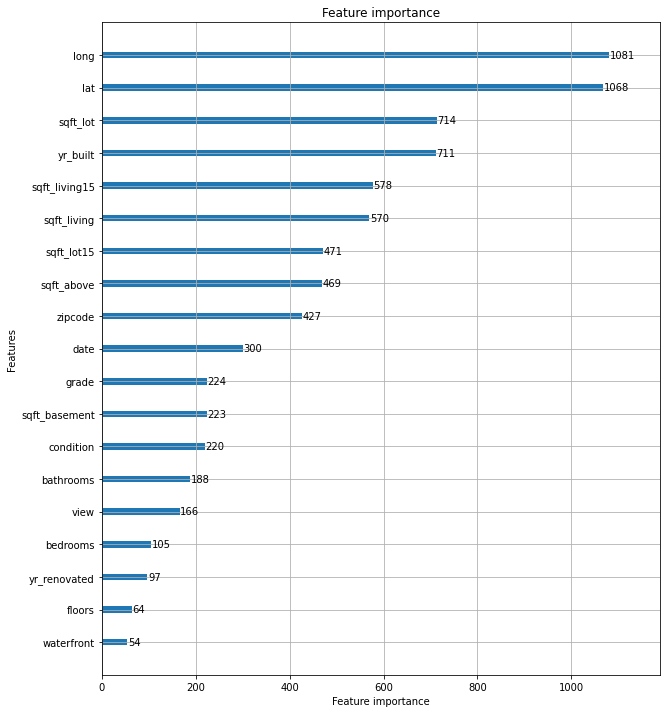

[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   5.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=  13.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   7.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=  10.2s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.1s
[CV] END ...................

In [82]:
# LightGBM에서도 plot_importance() API를 사용하면 피처의 중요도를 쉽게 시각화할 수 있다.
from lightgbm import plot_importance 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

하이퍼 파라미터 값 바꾸니까 이 표도 바뀌는거같다

**회고**

첫번째 시도 LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
115688.17397

두번째 시도 LGBMRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, random_state=random_state) 115688.17397

시험삼아 learning_rate를 지정해봤는데 초반부터 너무 작은 학습률을 지정하면 효율이 크게 떨어질 수 있기 때문이다. 정교한 결과를 위해, 마지막 순간에 더욱 좋은 결과를 도출하기 위해 후반에 지정하는게 좋다고 한다

세번째 시도 LGBMRegressor(max_depth=10, n_estimators=100, num_leaves=40, random_state=random_state) 115499.07583 순위가 올랐다?!

네번째 시도 LGBMRegressor(max_depth=10, n_estimators=100, num_leaves=40 ,random_state=random_state, boosting_type='rf')

Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp 오류 뜨면서 안됨 구글링 계속 해봤으나 해결책 찾지 못하였고 시간이 없어서 다른것부터 할거임

다섯번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=40 ,random_state=random_state) 115499.07583

똑같고 boosting_type='gbdt'는 기본값이라 그냥 된다

여섯번째 시도 다른 방법 있는가 싶어서 ipynb 다르게 만들어서 시도해봤는데 655151.45725위 뜸 더 만져봤는데 오류만 계속 떠서 다시 돌아옴 시간낭비 많이함

일곱번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=70 ,random_state=random_state) 111888.31861

여덞번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=98 ,random_state=random_state) 112877.92144 순위가 숫자를 더 올렸는데 순위가 내려감

아홉번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=80 ,random_state=random_state) 111123.83885

열번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=90 ,random_state=random_state) 111888.31861

열한번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=85 ,random_state=random_state) 111539.63168

열두번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=75 ,random_state=random_state) 111849.06673

열세번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=82 ,random_state=random_state) 111599.56988

열네번째 시도 LGBMRegressor(boosting_type='gbdt', max_depth=10, n_estimators=100, num_leaves=80 ,random_state=random_state) 111123.83885 다시 80으로 되돌림 80이 젤 잘나오는듯 80 고정으로 박고 다른거 고쳐봐야할듯

모델을 바꿔서 시도해보려고 했는데 한번은 오류뜨고 값 바꿔서 입력하니까 모래시계만 계속 뜨고 출력을 못함..

learning_rate=0.05다니까 랭킹이 올라감..

learning_rate=0.1하니까 원래대로 돌아감. 0.1이 기본값인가?



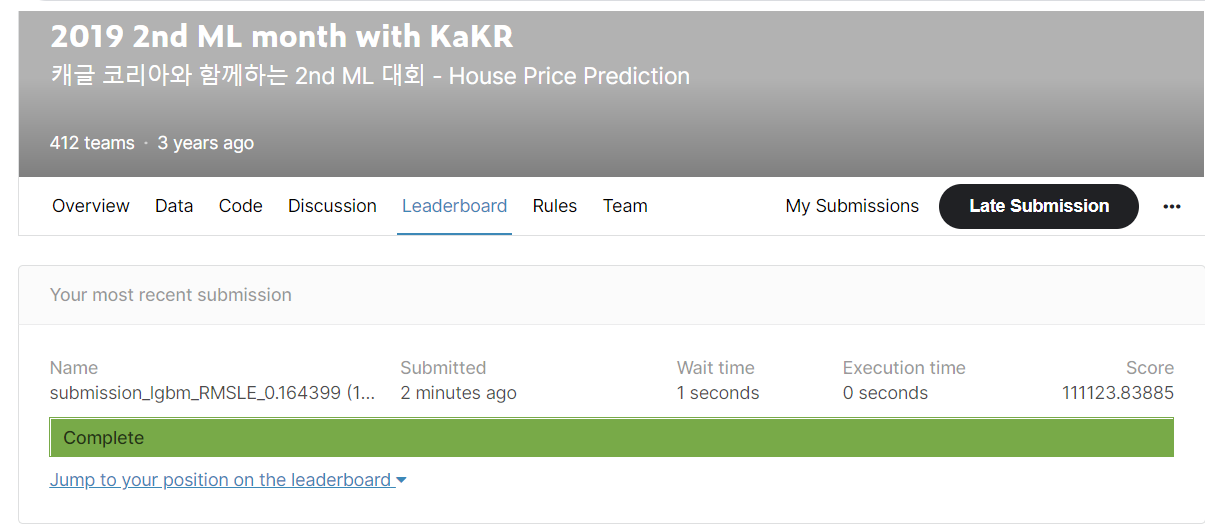